In [2]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigfra

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for enviro

Episode 0, Reward: 0.0, Success: 0.00, Epsilon: 0.995
Episode 100, Reward: 0.0, Success: 0.00, Epsilon: 0.603
Episode 200, Reward: 0.0, Success: 0.00, Epsilon: 0.365
Episode 300, Reward: 0.0, Success: 0.00, Epsilon: 0.221
Episode 400, Reward: 0.0, Success: 0.00, Epsilon: 0.134
Episode 500, Reward: 0.0, Success: 0.00, Epsilon: 0.081
Episode 600, Reward: 0.0, Success: 0.00, Epsilon: 0.049
Episode 700, Reward: 0.0, Success: 0.00, Epsilon: 0.030
Episode 800, Reward: 0.0, Success: 0.00, Epsilon: 0.018
Episode 900, Reward: 0.0, Success: 0.00, Epsilon: 0.011
Episode 1000, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1100, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1200, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1300, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1400, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1500, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1600, Reward: 0.0, Success: 0.00, Epsilon: 0.010
Episode 1700, Reward: 0.0, Success: 0.00, E

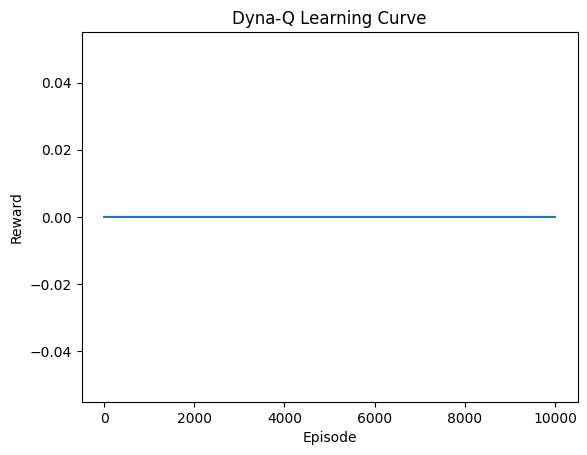

In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
from collections import defaultdict
import random
# Гиперпараметры
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 0.1
PLANNING_STEPS = 5  # Количество шагов планирования
EPISODES = 500
ENV_NAME = "FrozenLake-v1"  # Используем детерминированную версию
ALPHA = 0.5  # Более высокая скорость обучения
GAMMA = 0.95
EPSILON_DECAY = 0.995  # Затухание exploration
MIN_EPSILON = 0.01
PLANNING_STEPS = 50  # Увеличиваем планирование
EPISODES = 10000  # Больше эпизодов

# Инициализация Q-функции с оптимизмом


epsilon = 1.0  # Начинаем с полного exploration
rewards = []
success_rate = []
# Среда
env = gym.make(ENV_NAME, is_slippery=False)
env = RecordVideo(env, "videos", episode_trigger=lambda x: x % 50 == 0)

# Инициализация
n_states = env.observation_space.n
n_actions = env.action_space.n
Q = np.random.uniform(0, 0.1, (n_states, n_actions))

# Модель среды
model_R = np.zeros((n_states, n_actions))
model_T = np.zeros((n_states, n_actions), dtype=int)
visited = set()

# Функция выбора действия (ε-жадная)
def choose_action(state):
    if np.random.random() < EPSILON:
        return env.action_space.sample()
    return np.argmax(Q[state])

# Обучение
rewards = []
for episode in range(EPISODES):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    episode_reward = 0
    done = False

    while not done:
        # ε-жадное действие
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated

        # Важное исправление: учитываем терминальные состояния
        if terminated and reward == 0:  # Упали в лунку
            Q[state, action] = -1  # Явное наказание
        else:
            # Стандартное обновление Q
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + GAMMA * Q[next_state, best_next_action] * (not done)
            Q[state, action] += ALPHA * (td_target - Q[state, action])

        # Обновление модели
        model_R[state, action] = reward
        model_T[state, action] = next_state
        visited.add((state, action))

        # Усиленное планирование
        for _ in range(PLANNING_STEPS):
            if len(visited) == 0:
                break
            s, a = random.choice(list(visited))
            r = model_R[s, a]
            s_next = model_T[s, a]

            if r == 0 and s_next == s:  # Невалидный переход
                continue

            best_a = np.argmax(Q[s_next])
            td_target = r + GAMMA * Q[s_next, best_a]
            Q[s, a] += ALPHA * (td_target - Q[s, a])

        state = next_state
        episode_reward += reward

    # Затухание epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    # Отслеживание успешных эпизодов
    if reward > 0:
        success_rate.append(1)
    else:
        success_rate.append(0)

    rewards.append(episode_reward)

    if episode % 100 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}, Success: {np.mean(success_rate[-100:]):.2f}, Epsilon: {epsilon:.3f}")

env.close()

# Визуализация
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Dyna-Q Learning Curve")
plt.show()